In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import cv2
from IPython.display import Image

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = ImageDataGenerator()
test = ImageDataGenerator()

train_dataset = train.flow_from_directory(directory="/content/drive/MyDrive/cnn/data/train",
                                          target_size=(150,150),
                                          batch_size = 10,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory(directory="/content/drive/MyDrive/cnn/data/test",
                                          target_size=(150,150),
                                          batch_size =10,
                                          class_mode = 'binary')
                                         

Found 307 images belonging to 2 classes.
Found 119 images belonging to 2 classes.


In [31]:
# Directory with our training dandelion pictures
train_chilli_dir = os.path.join('/content/drive/MyDrive/cnn/data/train/chilli')

# Directory with our training grass pictures
train_turmeric_dir = os.path.join('/content/drive/MyDrive/cnn/data/train/turmeric')

# Directory with our validation dandelion pictures
valid_chilli_dir = os.path.join('/content/drive/MyDrive/cnn/data/test/chilli')

# Directory with our validation grass pictures
valid_turmeric_dir = os.path.join('/content/drive/MyDrive/cnn/data/test/turmeric')

In [32]:
train_chilli_names = os.listdir(train_chilli_dir)
print(train_chilli_names[:10])

train_turmeric_names = os.listdir(train_turmeric_dir)
print(train_turmeric_names[:10])

validation_chilli_hames = os.listdir(valid_chilli_dir)
print(validation_dandelion_hames[:10])

validation_turmeric_names = os.listdir(valid_turmeric_dir)
print(validation_turmeric_names[:10])

['0f6cf3150a.jpg', '000d8a61da.jpg', '0fbedfd5aa.jpg', '071faec038.jpg', '1f46f46398.jpg', '1053ec8c35.jpg', '1bc69c2aa7.jpg', '0887475294.jpg', '0c053156df.jpg', '23ed9f46d4.jpg']
['0560171a49.jpg', '00b9abc6cc.jpg', '02ae5f767f.jpg', '0327afdbfc.jpg', '0145d756d5.jpg', '02f4bfcaaf.jpg', '06014fb0a3.jpg', '132605a46b.jpg', '0d78c029c5.jpg', '194a8fcea6.jpg']
['b019fcf58d.jpg', 'c28c96ebe2.jpg', 'ba592eb0a8.jpg', 'd2e0174e2b.jpg', 'c553d684fa.jpg', 'dcf5393cbc.jpg', 'f26afd64c1.jpg', 'e03d725e1e.jpg', 'e04e0bdb1c.jpg', 'cef1adfa82.jpg']
['d6e9059431.jpg', 'd5487855dc.jpg', 'db385a388b.jpg', 'd44b623e50.jpg', 'd7a68506a0.jpg', 'd2ba79bcf5.jpg', 'd87e28245f.jpg', 'cc9e657e2e.jpg', 'd83122fcfd.jpg', 'dc36c1146c.jpg']


In [10]:
print('total training chilli images:', len(os.listdir(train_chilli_dir)))
print('total training turmeric images:', len(os.listdir(train_turmeric_dir)))
print('total validation chilli images:', len(os.listdir(valid_chilli_dir)))
print('total validation turmeric images:', len(os.listdir(valid_turmeric_dir)))

total training chilli images: 154
total training turmeric images: 153
total validation chilli images: 60
total validation turmeric images: 59


In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

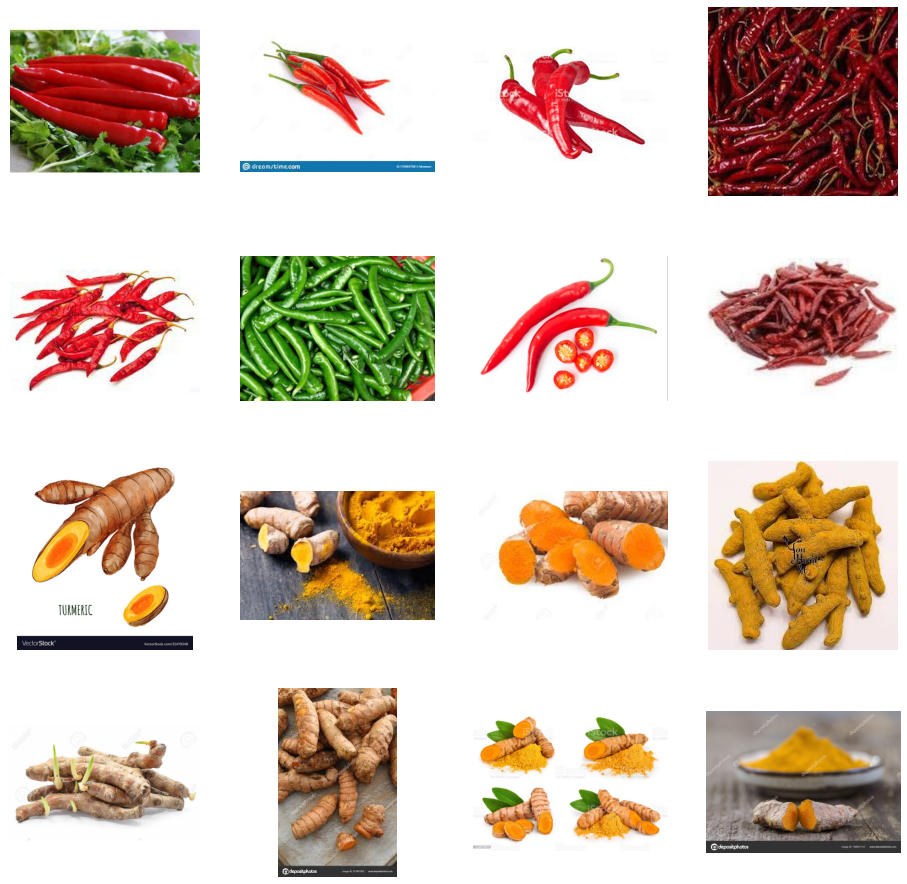

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_chilli_pic = [os.path.join(train_chilli_dir, fname) 
                for fname in train_chilli_names[pic_index-8:pic_index]]
next_turmeric_pic = [os.path.join(train_turmeric_dir, fname) 
                for fname in train_turmeric_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_chilli_pic + next_turmeric_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/cnn/data/train/',  # This is the source directory for training images
        classes = ['chilli', 'turmeric'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/cnn/data/test/',  # This is the source directory for training images
        classes = ['chilli', 'turmeric'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 307 images belonging to 2 classes.
Found 119 images belonging to 2 classes.


Building the model

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [15]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(200, 200, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
from tensorflow.keras.optimizers import RMSprop

# model.compile(loss='binary_crossentropy',
#               optimizer=RMSprop(lr=0.001),
#               metrics=['accuracy', tf.keras.metrics.AUC()])

from tensorflow.keras import optimizers


model.compile(optimizer=RMSprop(learning_rate=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')

In [18]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 100s 11s/step - loss: 1.5858 - accuracy: 0.5440 - val_loss: 0.2203 - val_accuracy: 0.9328


In [19]:
model.evaluate(validation_generator)

7/7 [==============================] - 4s 509ms/step - loss: 0.2203 - accuracy: 0.9328


[0.22032293677330017, 0.9327731132507324]

In [20]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

7/7 [==============================] - 5s 539ms/step


In [21]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [22]:
roc_auc = auc(fpr, tpr)

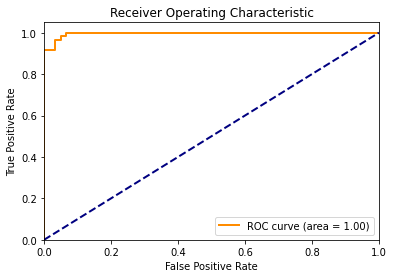

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Saving image.jpg to image.jpg
[0.16087061]
image.jpg is turmeric


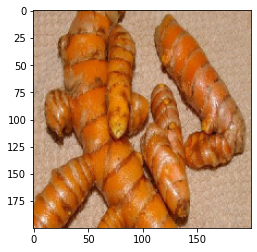

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is turmeric")
  else:
    print(fn + " is a chilli")
 

Saving image2.jpg to image2 (1).jpg
[0.79151046]
image2.jpg is chilli


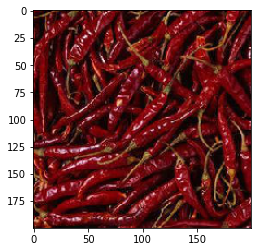

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is turmeric")
  else:
    print(fn + " is chilli")
 

Saving img1.jpg to img1 (1).jpg
[0.48131078]
img1.jpg is turmeric


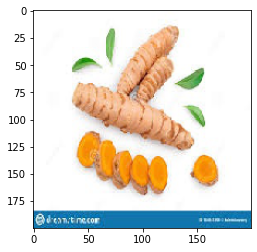

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is turmeric")
  else:
    print(fn + " is chilli")
 